In [1]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=fea96b0cb4ce98bdada16ba664fc7f65a96da0f05c880505027901e714fcfe0b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

In [3]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=True):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
#         if self.norm_pix_loss:
#             mean = target.mean(dim=-1, keepdim=True)
#             var = target.var(dim=-1, keepdim=True)
#             target = (target - mean) / (var + 1.e-6)**.5

#         loss = (pred - target) ** 2
#         loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

#         loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        img_size=125, patch_size=5, in_chans=8, embed_dim=128, depth=8, num_heads=8,
        decoder_embed_dim=128, decoder_depth=8, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
model = mae_vit_base_patch16_dec512d8b()  # decoder: 512 dim, 8 blocks

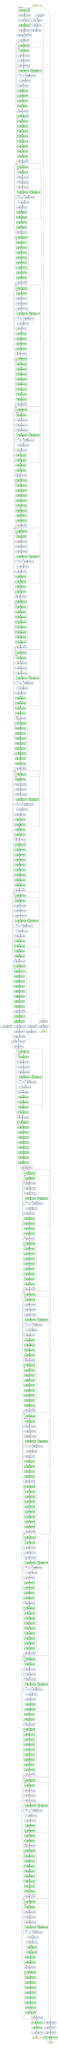

In [4]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [5]:
import os
print(os.listdir("/kaggle/input/"))

X_train = np.load('/kaggle/input/train_dataset.npy')

X_train.shape

X_test = np.load('/kaggle/input/test_dataset.npy')

X_test.shape
X_train /=255.0
X_test /=255.0

['train_dataset.npy', 'test_dataset.npy']


In [6]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = torch.from_numpy(self.x[idx]).moveaxis(2, 0)
        sample = {'img' : img_1}
        
        return sample
dataset = Custom_Dataset(X_train)
sample = dataset.__getitem__(0)
inp = []
inp.append(dataset.__getitem__(0)['img'].unsqueeze(0))
inp.append(dataset.__getitem__(1)['img'].unsqueeze(0))
inp = torch.cat(inp, axis = 0)
print("X_train shape:", X_train.shape)
print("Sample image shape:", sample['img'].shape)
print("Sample image values:", sample['img'].max())

X_train shape: (32000, 125, 125, 8)
Sample image shape: torch.Size([8, 125, 125])
Sample image values: tensor(1.)


In [7]:
loss, pred, mask = model(inp.to('cuda'))

In [8]:
inp.shape

torch.Size([2, 8, 125, 125])

In [9]:
pred.shape

torch.Size([2, 625, 200])

In [10]:
loss

tensor(0.8356, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [11]:
import numpy as np
import torch

# def custom_loss(imgs, pred, mask):

#     L = 0
#     for i in range(len(mask)):
#         l = ((pred[:, : ,i, :] - imgs[:, : ,i, :])**2).unsqueeze(axis = 2).mean(axis = -1)
#         # Move the mask tensor to the CPU before converting it to a NumPy array
#         mask_cpu = mask[i].unsqueeze(axis = -1)
#         loss = (l * mask_cpu).sum()
#         L+=((loss / mask_cpu.sum()))
    
#     return L/8
def bcelogitsloss(output, labels):
    criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
    loss = 0
#     output = torch.cat(output, axis = 1)
#     for i in range(8):
#         op = output[i].squeeze(1)
#         print(op.shape)
#         lab = labels[:, i,:,:].to('cuda')
#         loss += criterion(op, lab)
    loss+=criterion(output, labels)
    return loss

# print(bcelogitsloss(pred, inp))

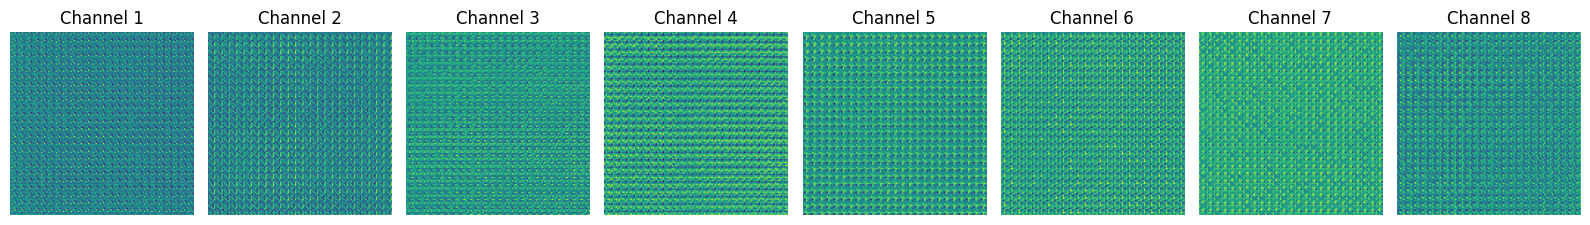

In [12]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

def visualize_prediction(pred):
    # Reshape prediction for visualization
    # preds = pred.reshape((pred.shape[0], 625, 200))

    def unpatchify(x):
        """
        x: (N, L, patch_size**2 * 3)
        imgs: (N, 8, H, W)
        """
        p = 5
        h = w = int(x.shape[1]**0.5)
        assert h * w == x.shape[1]
        
        x = x.reshape((x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape((x.shape[0], 8, h * p, w * p))
        return imgs

    # Unpatchify the prediction
    preds = unpatchify(pred)[0]
#     preds = torch.cat(pred, axis = 1)
#     preds = preds[0]

    # Convert to numpy array and move to CPU if necessary
    img = preds.permute(1, 2, 0).cpu().detach().numpy()

    # Number of channels
    num_channels = img.shape[2]

    # Create a single row of subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(16, 4))

    # Iterate through channels and plot each one in a subplot
    for i in range(num_channels):
        axes[i].imshow(img[:,:,i])  # Adjust colormap as needed
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()
# preds = torch.cat(pred, axis = 1)
# print(preds.shape)
visualize_prediction(pred)

In [13]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy

# Define your Custom_Dataset class here (assuming it's defined earlier)

# Define your MaskedAutoencoderViT class here (assuming it's defined earlier)

def model_train(model, epochs, train_dataloader, val_dataloader, device):
#     criterion = custom_loss()
    optimizer = AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            images = batch['img'].to(device)

            optimizer.zero_grad()
            loss, outputs, mask = model(images)
#             loss = bcelogitsloss(outputs, images)
            loss = loss.sum()
            loss.backward()
            optimizer.step()

            train_loss += loss

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        original_image = None
        reconstructed_image = None
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Val)', unit='batch'):
                images = batch['img'].to(device).float()
                loss, outputs, mask= model(images)
                loss =loss.sum()
#                 loss = bcelogitsloss(outputs, images)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        scheduler.step() 
        
        if epoch % 5 == 0:
            visualize_prediction(outputs)
#         channel_wise_visualization(original_image[0], reconstructed_image[0])

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:  # Open file in append mode
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
    
        torch.save(model.module.state_dict(), f'./full_model.pth')
    
    return train_losses, val_losses

# Assuming dataset, train_dataloader, and val_dataloader are defined earlier

# Define your model
# del model
gc.collect()
torch.cuda.empty_cache()

In [14]:
del model
gc.collect()
torch.cuda.empty_cache()
model = mae_vit_base_patch16_dec512d8b()

In [15]:
train_dataset = Custom_Dataset(X_train)
test_dataset = Custom_Dataset(X_test)
training_loss = []
validation_loss = []
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

DEVICE = torch.torch.device("cuda")
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    model = nn.DataParallel(model)
model = model.to(DEVICE)

Epoch 1/40 (Train):   0%|          | 0/125 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch 1/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


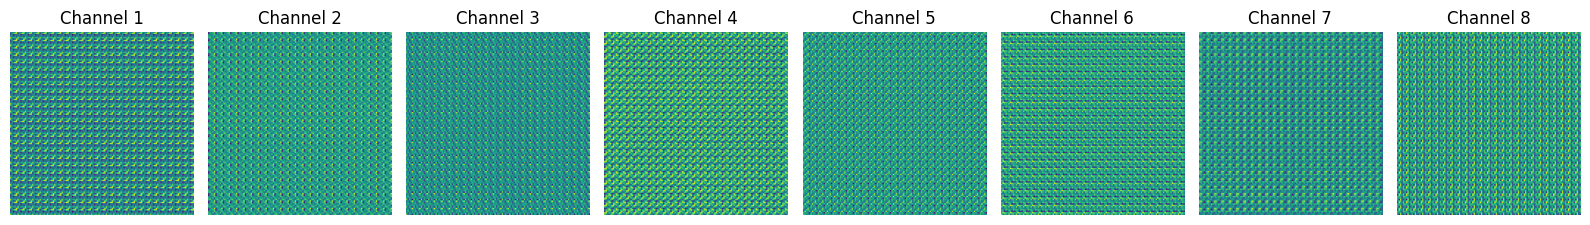

Epoch 1/40, Train Loss: 0.5368, Val Loss: 0.2319


Epoch 2/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 2/40, Train Loss: 0.1469, Val Loss: 0.0975


Epoch 3/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 3/40, Train Loss: 0.0754, Val Loss: 0.0628


Epoch 4/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 4/40, Train Loss: 0.0535, Val Loss: 0.0498


Epoch 5/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 5/40, Train Loss: 0.0443, Val Loss: 0.0438


Epoch 6/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


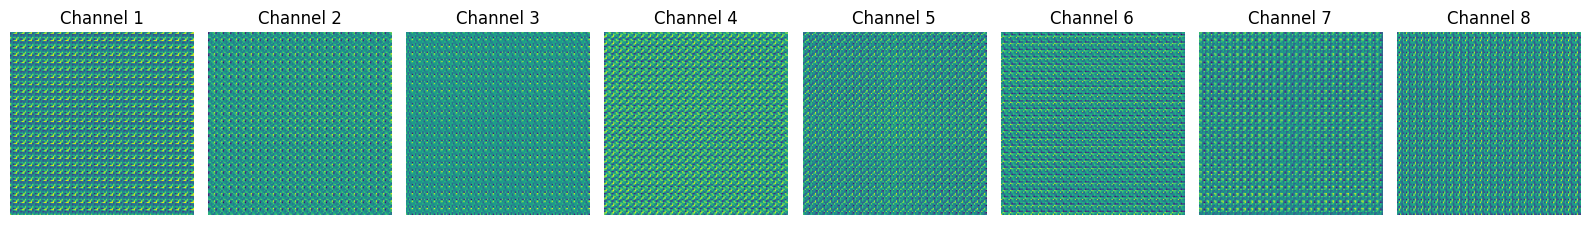

Epoch 6/40, Train Loss: 0.0398, Val Loss: 0.0406


Epoch 7/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 7/40, Train Loss: 0.0373, Val Loss: 0.0388


Epoch 8/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 8/40, Train Loss: 0.0353, Val Loss: 0.0360


Epoch 9/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 9/40, Train Loss: 0.0322, Val Loss: 0.0341


Epoch 10/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 10/40, Train Loss: 0.0310, Val Loss: 0.0332


Epoch 11/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


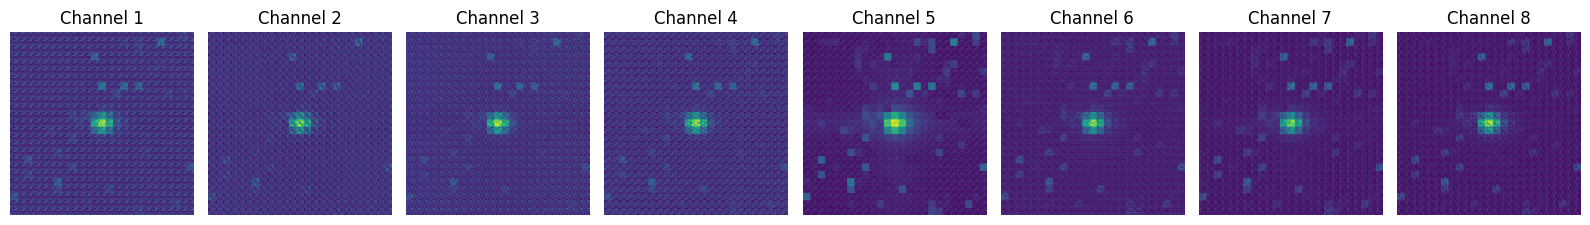

Epoch 11/40, Train Loss: 0.0302, Val Loss: 0.0327


Epoch 12/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 12/40, Train Loss: 0.0297, Val Loss: 0.0322


Epoch 13/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 13/40, Train Loss: 0.0293, Val Loss: 0.0319


Epoch 14/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 14/40, Train Loss: 0.0289, Val Loss: 0.0315


Epoch 15/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 15/40, Train Loss: 0.0286, Val Loss: 0.0312


Epoch 16/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


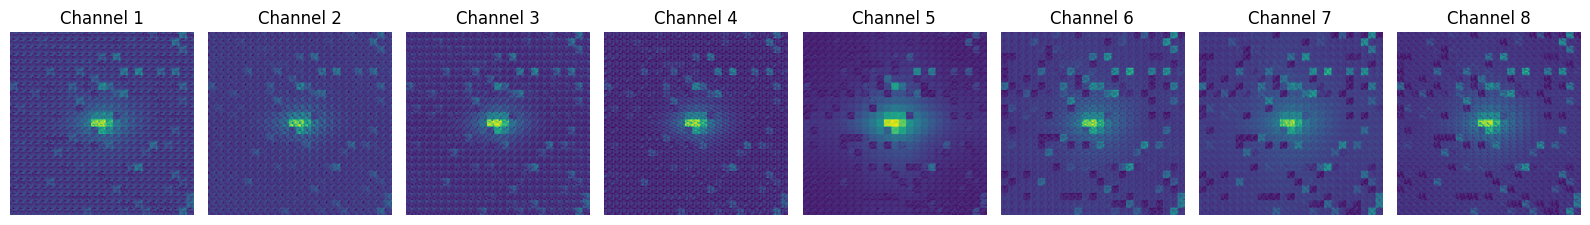

Epoch 16/40, Train Loss: 0.0283, Val Loss: 0.0310


Epoch 17/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 17/40, Train Loss: 0.0280, Val Loss: 0.0307


Epoch 18/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 18/40, Train Loss: 0.0276, Val Loss: 0.0301


Epoch 19/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 19/40, Train Loss: 0.0271, Val Loss: 0.0297


Epoch 20/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 20/40, Train Loss: 0.0266, Val Loss: 0.0292


Epoch 21/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


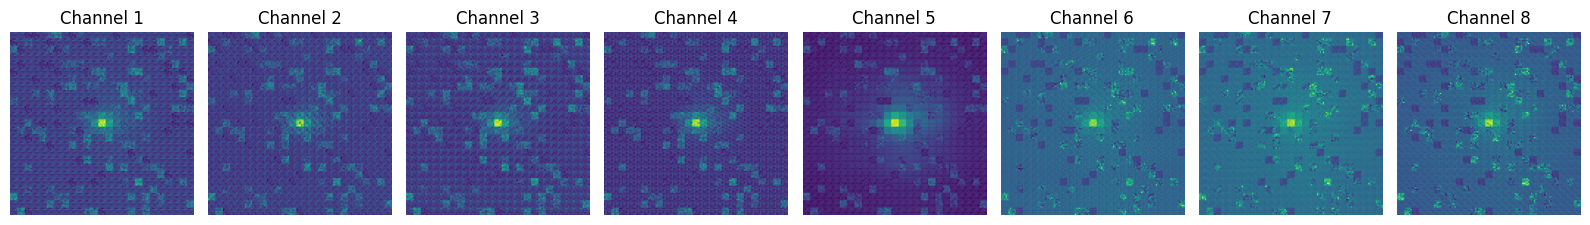

Epoch 21/40, Train Loss: 0.0263, Val Loss: 0.0289


Epoch 22/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Epoch 22/40, Train Loss: 0.0260, Val Loss: 0.0286


Epoch 23/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 23/40, Train Loss: 0.0257, Val Loss: 0.0284


Epoch 24/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 24/40, Train Loss: 0.0256, Val Loss: 0.0282


Epoch 25/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 25/40, Train Loss: 0.0254, Val Loss: 0.0281


Epoch 26/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


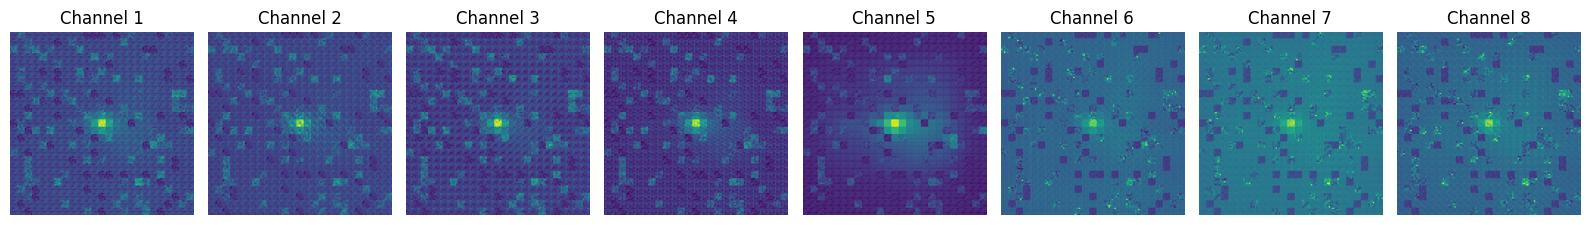

Epoch 26/40, Train Loss: 0.0253, Val Loss: 0.0279


Epoch 27/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 27/40, Train Loss: 0.0251, Val Loss: 0.0278


Epoch 28/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 28/40, Train Loss: 0.0250, Val Loss: 0.0277


Epoch 29/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 29/40, Train Loss: 0.0250, Val Loss: 0.0277


Epoch 30/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 30/40, Train Loss: 0.0249, Val Loss: 0.0276


Epoch 31/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


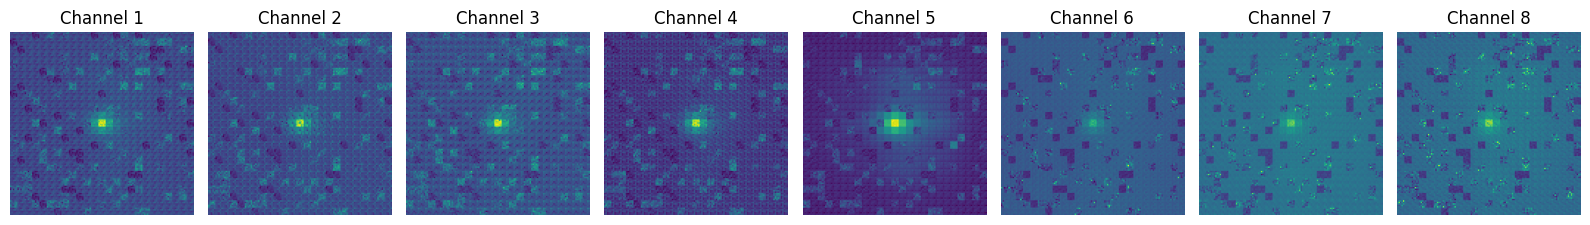

Epoch 31/40, Train Loss: 0.0248, Val Loss: 0.0275


Epoch 32/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 32/40, Train Loss: 0.0248, Val Loss: 0.0275


Epoch 33/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Epoch 33/40, Train Loss: 0.0247, Val Loss: 0.0274


Epoch 34/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 34/40, Train Loss: 0.0247, Val Loss: 0.0274


Epoch 35/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 35/40, Train Loss: 0.0247, Val Loss: 0.0274


Epoch 36/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


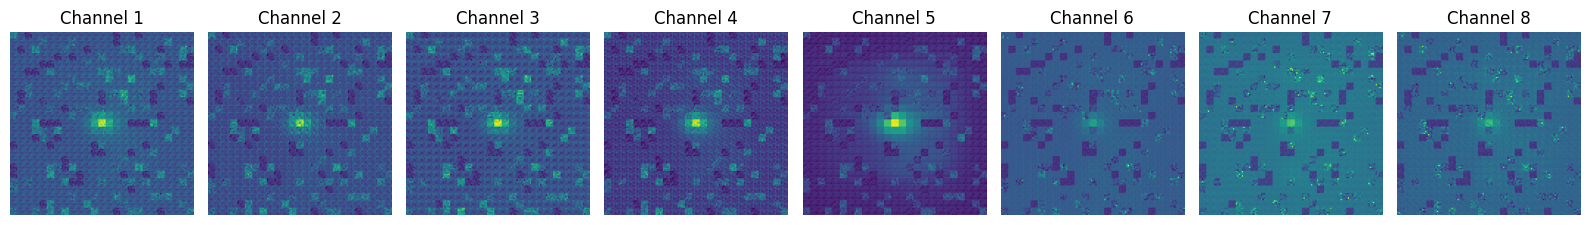

Epoch 36/40, Train Loss: 0.0247, Val Loss: 0.0274


Epoch 37/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 37/40, Train Loss: 0.0246, Val Loss: 0.0274


Epoch 38/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 38/40, Train Loss: 0.0246, Val Loss: 0.0273


Epoch 39/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Epoch 39/40, Train Loss: 0.0246, Val Loss: 0.0273


Epoch 40/40 (Val): 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]

Epoch 40/40, Train Loss: 0.0246, Val Loss: 0.0273


In [16]:
train_losses, val_losses = model_train(model, 40, train_dataloader, val_dataloader, DEVICE)